In [1]:
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

file_paths = glob.glob("../data/*.gz")

df = pd.concat(
    (pd.read_csv(file) for file in file_paths),
    ignore_index=True
)

# Convert to datetime FIRST
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

# Then compute difference
df["days_since_install"] = (
        df["event_date"] - df["install_date"]
).dt.days

# First-day behavior
day0 = df[df["days_since_install"] == 0]

engagement_day0 = (
    day0.groupby("user_id")
    .agg(
        sessions=("total_session_count", "sum"),
        duration=("total_session_duration", "sum"),
        matches=("match_start_count", "sum"),
        iap=("iap_revenue", "sum"),
        ads=("ad_revenue", "sum")
    )
    .reset_index()
)

engagement_day0["total_revenue"] = (
        engagement_day0["iap"] + engagement_day0["ads"]
)

In [2]:
from sklearn.preprocessing import StandardScaler

features = ["sessions", "duration", "matches"]

scaler = StandardScaler()
scaled = scaler.fit_transform(engagement_day0[features])

engagement_day0[["sessions_z", "duration_z", "matches_z"]] = scaled

engagement_day0["engagement_score"] = (
        engagement_day0["sessions_z"] +
        engagement_day0["duration_z"] +
        engagement_day0["matches_z"]
)

# Engage users to 4 groups

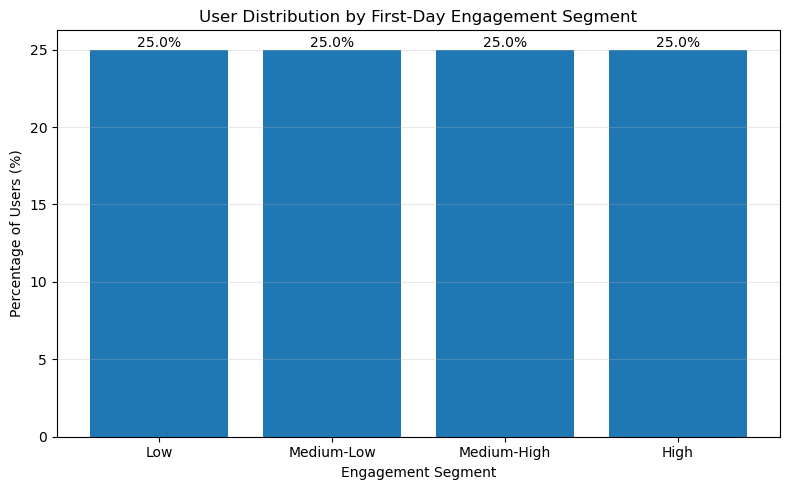

  engagement_segment       min         max      mean   count
0                Low -3.290106   -1.458502 -1.674438  264213
1         Medium-Low -1.458501   -0.927808 -1.269792  264213
2        Medium-High -0.927805    0.593197 -0.243535  264213
3               High  0.593228  624.788826  3.187765  264213


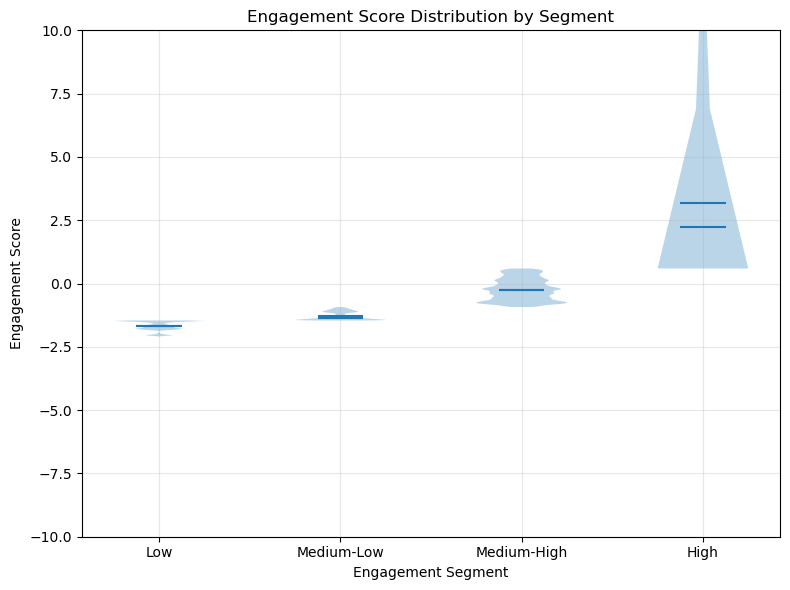

In [3]:
import matplotlib.pyplot as plt
import numpy as np

engagement_day0["engagement_segment"] = pd.qcut(
    engagement_day0["engagement_score"],
    q=4,
    labels=["Low", "Medium-Low", "Medium-High", "High"]
)

segment_distribution = (
        engagement_day0["engagement_segment"]
        .value_counts(normalize=True)
        .sort_index()
        * 100
)

plt.figure(figsize=(8,5))

bars = plt.bar(
    segment_distribution.index,
    segment_distribution.values
)

plt.xlabel("Engagement Segment")
plt.ylabel("Percentage of Users (%)")
plt.title("User Distribution by First-Day Engagement Segment")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

segment_ranges = (
    engagement_day0
    .groupby("engagement_segment")["engagement_score"]
    .agg(["min", "max", "mean", "count"])
    .reset_index()
)

print(segment_ranges)

plt.figure(figsize=(8,6))

# Prepare data in correct order
segments = ["Low", "Medium-Low", "Medium-High", "High"]
data = [
    engagement_day0[
        engagement_day0["engagement_segment"] == seg
        ]["engagement_score"]
    for seg in segments
]

plt.violinplot(
    data,
    showmeans=True,
    showmedians=True,
    showextrema=False   # removes whisker dots
)

plt.xticks(np.arange(1, len(segments)+1), segments)

plt.xlabel("Engagement Segment")
plt.ylabel("Engagement Score")
plt.title("Engagement Score Distribution by Segment")
plt.ylim(-10,10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

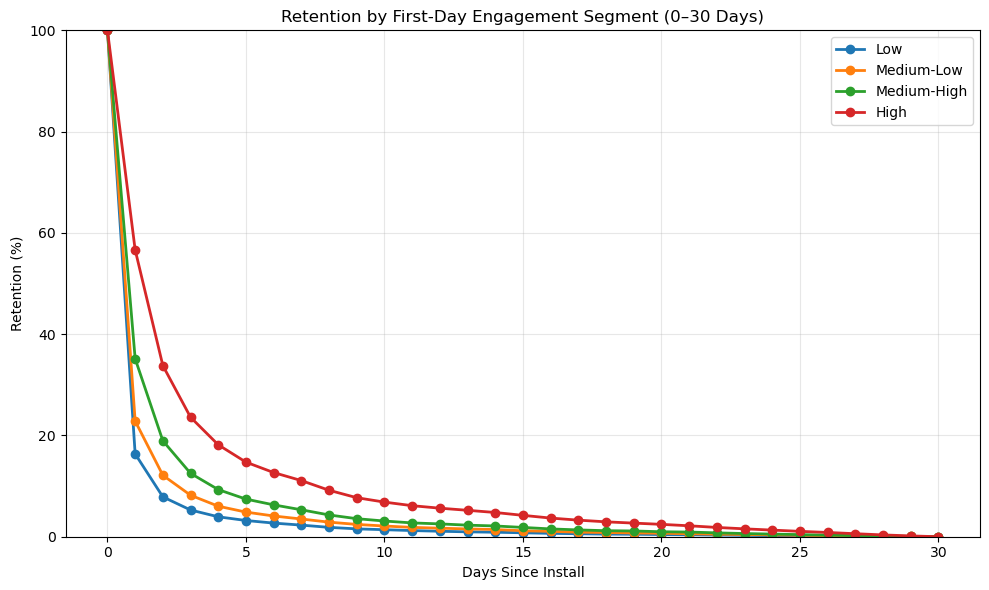

In [4]:
df_segmented = df.merge(
    engagement_day0[["user_id", "engagement_segment"]],
    on="user_id",
    how="left"
)


df_segmented = df_segmented[
    df_segmented["days_since_install"] >= 0
    ].copy()

df_segmented["days_since_install"] = (
        df_segmented["event_date"] - df_segmented["install_date"]
).dt.days

retention_segment = (
    df_segmented.groupby(
        ["engagement_segment", "days_since_install"]
    )["user_id"]
    .nunique()
    .reset_index(name="active_users")
)

# Cohort size per segment (Day 0 users only)
cohort_segment = (
    df_segmented[df_segmented["days_since_install"] == 0]
    .groupby("engagement_segment")["user_id"]
    .nunique()
    .reset_index(name="cohort_size")
)

retention_segment = retention_segment.merge(
    cohort_segment,
    on="engagement_segment"
)

retention_segment["retention_rate"] = (
        retention_segment["active_users"] /
        retention_segment["cohort_size"]
)

plt.figure(figsize=(10,6))

segments = ["Low", "Medium-Low", "Medium-High", "High"]

for seg in segments:

    subset = retention_segment[
        (retention_segment["engagement_segment"] == seg) &
        (retention_segment["days_since_install"] <= 30)
        ]

    plt.plot(
        subset["days_since_install"],
        subset["retention_rate"] * 100,
        marker="o",
        linewidth=2,
        label=seg
    )

plt.xlabel("Days Since Install")
plt.ylabel("Retention (%)")
plt.title("Retention by First-Day Engagement Segment (0–30 Days)")
plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



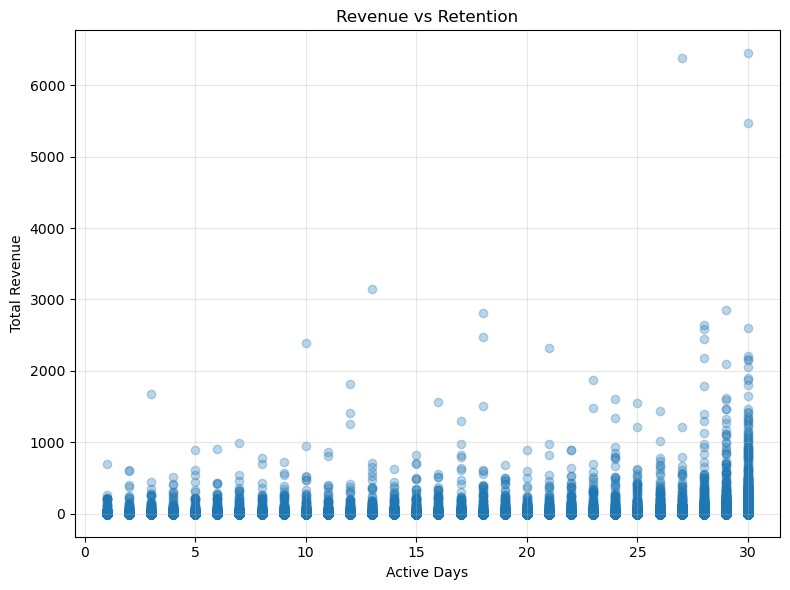

In [5]:
user_summary = (
    df_segmented.groupby("user_id")
    .agg(
        active_days=("days_since_install", "nunique"),
        total_revenue=("iap_revenue", "sum")
    )
    .reset_index()
)

plt.figure(figsize=(8,6))

plt.scatter(
    user_summary["active_days"],
    user_summary["total_revenue"],
    alpha=0.3
)

plt.xlabel("Active Days")
plt.ylabel("Total Revenue")
plt.title("Revenue vs Retention")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

DAU composition

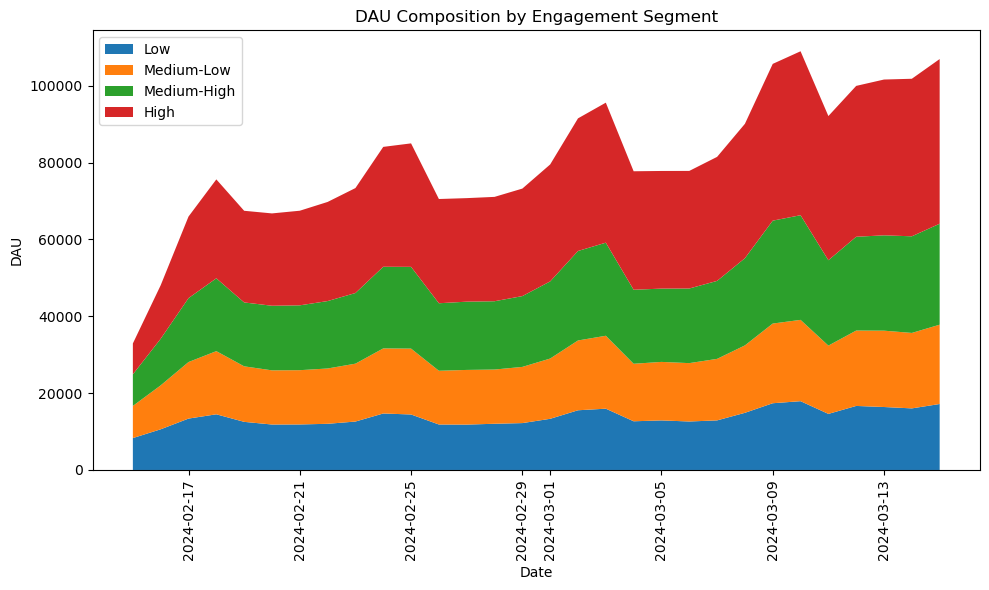

In [6]:
dau_segment = (
    df_segmented.groupby(["event_date", "engagement_segment"])["user_id"]
    .nunique()
    .reset_index()
)

pivot_dau = dau_segment.pivot(
    index="event_date",
    columns="engagement_segment",
    values="user_id"
).fillna(0)

plt.figure(figsize=(10,6))

plt.stackplot(
    pivot_dau.index,
    pivot_dau.T,
    labels=pivot_dau.columns
)

plt.xlabel("Date")
plt.ylabel("DAU")
plt.title("DAU Composition by Engagement Segment")

plt.xticks(rotation=90)   # ✅ make dates vertical

plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

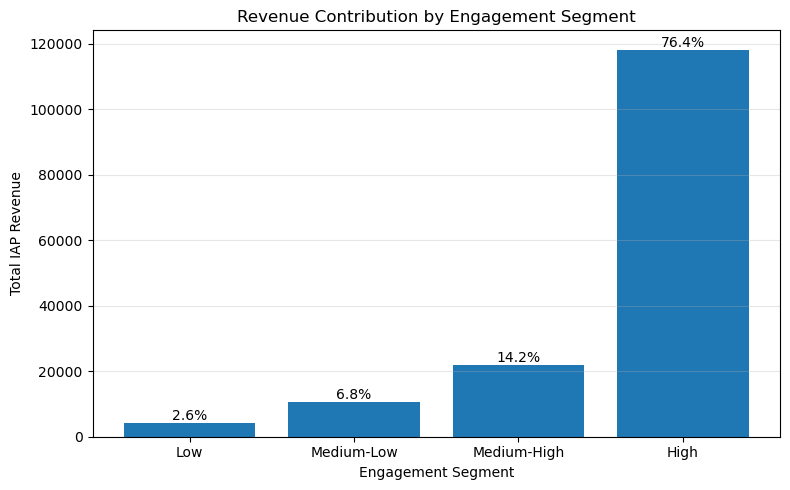

In [7]:
segment_revenue = (
    df_segmented.groupby("engagement_segment")["iap_revenue"]
    .sum()
    .reindex(["Low", "Medium-Low", "Medium-High", "High"])
)

total_revenue = segment_revenue.sum()

plt.figure(figsize=(8,5))

bars = plt.bar(
    segment_revenue.index,
    segment_revenue.values
)

plt.xlabel("Engagement Segment")
plt.ylabel("Total IAP Revenue")
plt.title("Revenue Contribution by Engagement Segment")
plt.grid(axis="y", alpha=0.3)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_revenue) * 100

    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

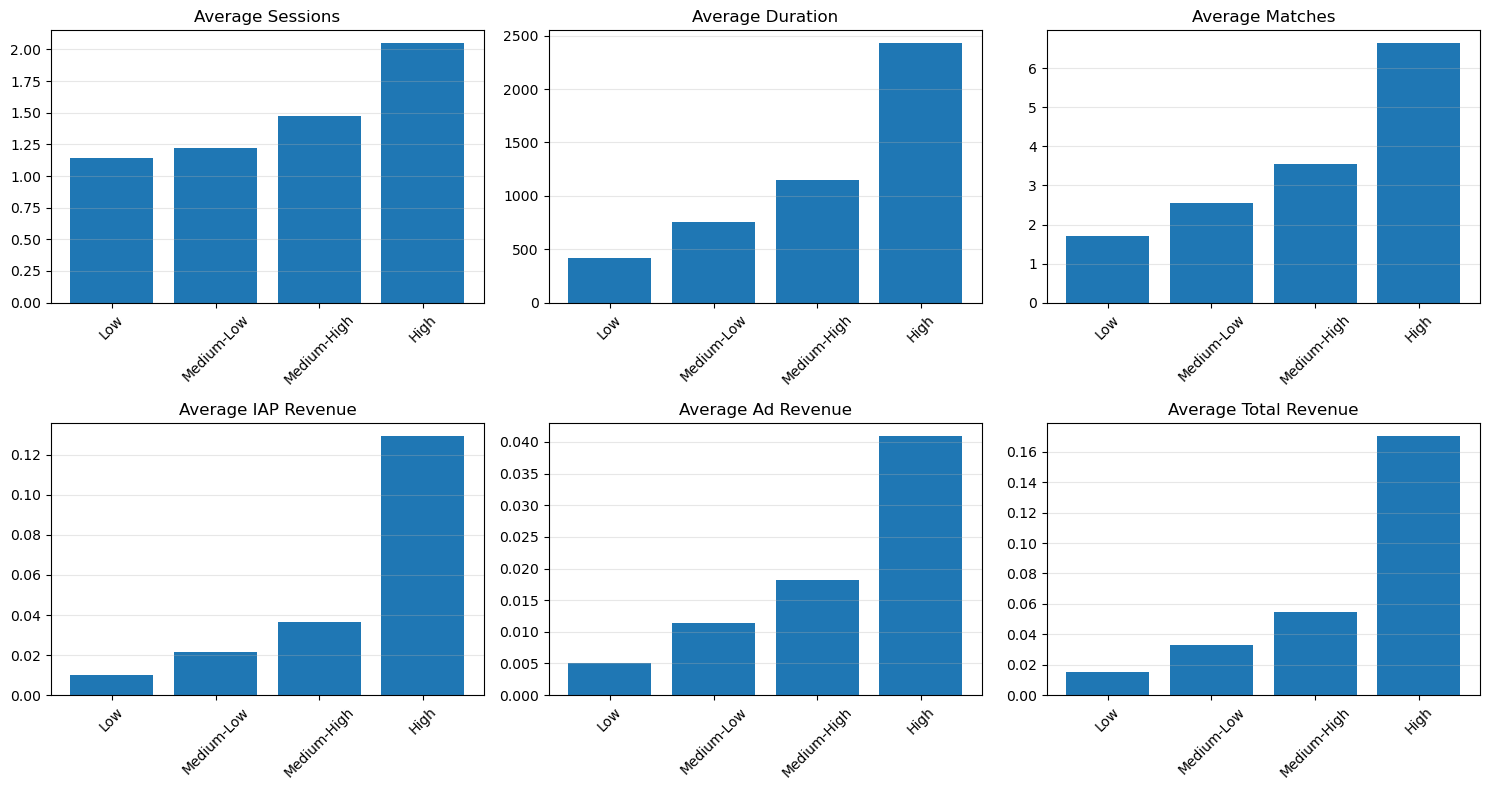

In [8]:
feature_summary = (
    df_segmented.groupby("engagement_segment")
    .agg(
        avg_sessions=("total_session_count", "mean"),
        avg_duration=("total_session_duration", "mean"),
        avg_matches=("match_start_count", "mean"),
        avg_iap=("iap_revenue", "mean"),
        avg_ads=("ad_revenue", "mean")
    )
    .reindex(["Low", "Medium-Low", "Medium-High", "High"])
)

feature_summary["avg_total_revenue"] = (
        feature_summary["avg_iap"] +
        feature_summary["avg_ads"]
)

import matplotlib.pyplot as plt

# Ensure correct order
feature_summary = feature_summary.reindex(
    ["Low", "Medium-Low", "Medium-High", "High"]
)

features = [
    "avg_sessions",
    "avg_duration",
    "avg_matches",
    "avg_iap",
    "avg_ads",
    "avg_total_revenue"
]

titles = [
    "Average Sessions",
    "Average Duration",
    "Average Matches",
    "Average IAP Revenue",
    "Average Ad Revenue",
    "Average Total Revenue"
]

fig, axes = plt.subplots(2, 3, figsize=(15,8))

axes = axes.flatten()

for i, feature in enumerate(features):

    axes[i].bar(
        feature_summary.index,
        feature_summary[feature]
    )

    axes[i].set_title(titles[i])
    axes[i].grid(axis="y", alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

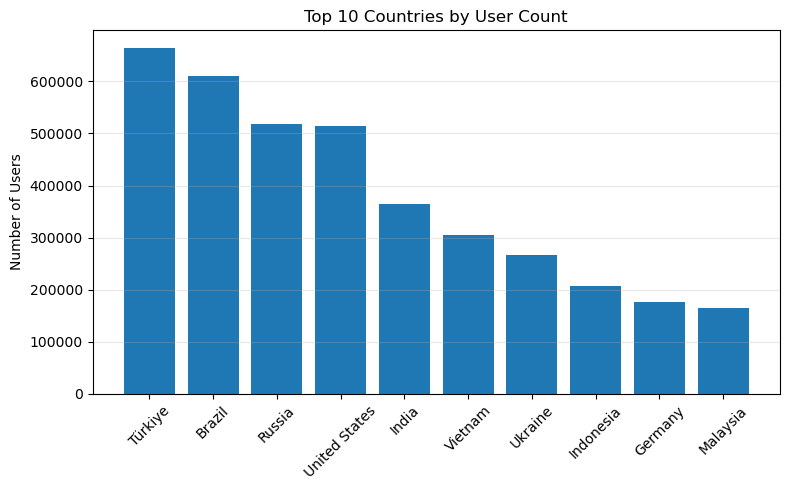

In [9]:
country_segment = (
    df_segmented.groupby(["engagement_segment", "country"])["user_id"]
    .nunique()
    .reset_index()
)

# Convert to percentage within segment
country_segment["segment_total"] = (
    country_segment.groupby("engagement_segment")["user_id"]
    .transform("sum")
)

country_segment["percentage"] = (
        country_segment["user_id"] /
        country_segment["segment_total"] * 100
)

# Keep top 5 countries per segment for clarity
top_countries = (
    country_segment.sort_values(["engagement_segment", "percentage"], ascending=False)
    .groupby("engagement_segment")
    .head(5)
)

top_countries

country_counts = (
    df_segmented["country"]
    .value_counts()
    .head(10)
)

plt.figure(figsize=(8,5))

plt.bar(country_counts.index, country_counts.values)

plt.title("Top 10 Countries by User Count")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

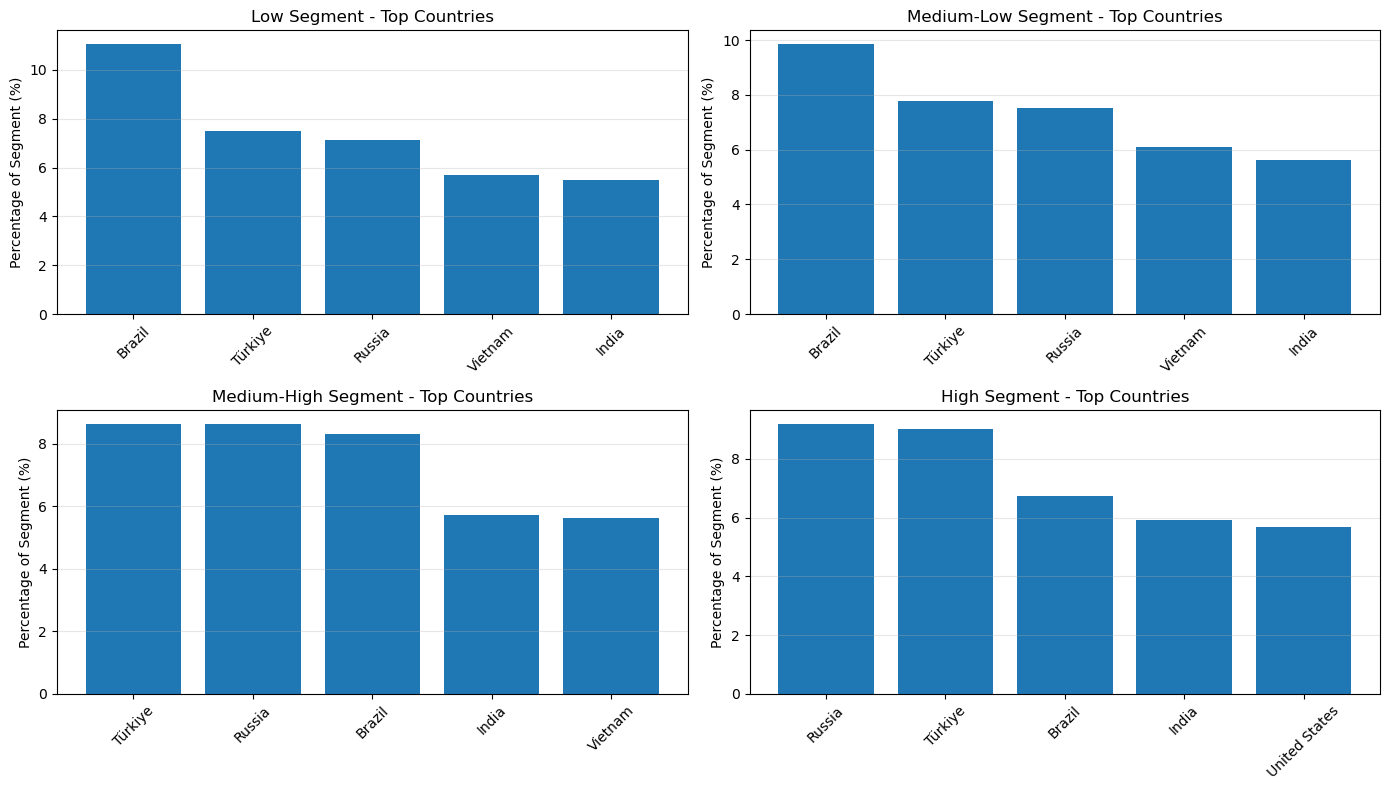

In [10]:
import matplotlib.pyplot as plt

segments = ["Low", "Medium-Low", "Medium-High", "High"]

fig, axes = plt.subplots(2, 2, figsize=(14,8))
axes = axes.flatten()

for i, seg in enumerate(segments):

    subset = top_countries[
        top_countries["engagement_segment"] == seg
        ]

    axes[i].bar(
        subset["country"],
        subset["percentage"]
    )

    axes[i].set_title(f"{seg} Segment - Top Countries")
    axes[i].set_ylabel("Percentage of Segment (%)")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()